In [48]:
import os
import pandas as pd
import numpy as np
import joblib as jl

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from tangle.mbspbs10pc import mbs_online
reload(mbs_online);

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/samu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load data

In [49]:
labels = pd.read_csv('../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
# data = pd.read_csv('../../tmp/raw_sequences.csv', header=0, index_col=0).loc[labels.index, 'seq']
data = jl.load(open('../../tmp/item_days_raw_data_.pkl','rb')).loc[labels.index, 'seq']

df = pd.DataFrame(columns=['Seq', 'Class', 'mbs_seq', 'times_seq'], index=data.index)

df.loc[:, 'Seq'] = data
df.loc[:, 'Class'] = labels['CLASS']

for idx in df.index:
    _tmp = df.loc[idx, 'Seq'].split(' ')
    df.loc[idx, 'mbs_seq'] = ' '.join(_tmp[::2])
    df.loc[idx, 'times_seq'] = ' '.join(_tmp[1::2])

In [50]:
df.head()

,Seq,Class,mbs_seq,times_seq
PIN,,,,
568483,10990 0 23 16 725 0 10990 0 10990 0 10990 0 10...,1,10990 23 725 10990 10990 10990 10993 23 85311 ...,0 16 0 0 0 0 0 15 0 0 13 0 0 0 22 0 0 0 0 0 0 ...
923748,66653 0 65070 0 66515 5 10962 1 105 1 56807 42...,0,66653 65070 66515 10962 105 56807 10990 23 109...,0 0 5 1 1 42 0 26 35 0 0 0 9 0 0 0 5 0 0 0 21 ...
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0,66536 74995 66512 66551 66608 66716 66560 7392...,0 0 0 0 0 0 0 9 1 10 9 138 1 3 31 24 63 0 0 0 ...
2239386,10991 0 23 105 73928 0 66560 0 66515 0 66551 0...,1,10991 23 73928 66560 66515 66551 66536 2517 10...,0 105 0 0 0 0 4 2 27 1 1 7 0 18 132 0 0 0 1 0 ...
2244533,10990 0 23 74 23 0 10990 1 73928 0 66500 0 665...,1,10990 23 23 10990 73928 66500 66560 66551 23 1...,0 74 0 1 0 0 0 2 0 87 0 1 0 0 0 0 0 2 0 6 0 8 ...


# Seq2token

In [51]:
# Define tokenizer object
seq_tokenizer = Tokenizer(char_level=False, lower=False, split=' ')

# Fit on corpus and extract tokenized sequences
seq_tokenizer.fit_on_texts(df['mbs_seq'])
mbs_tokens = map(int, seq_tokenizer.word_index.keys())
print(len(mbs_tokens))
print(mbs_tokens[:3])

2773
[65096, 65093, 65090]


# Get tokens from `item_map.tsv`

In [64]:
item_map = pd.read_csv('../../mbspbs10pc/data/item_map.tsv', sep='\t', header=0, index_col=0)
item_map.head()

,MAPPED_ITEM,Item_Start_Date,Item_End_Date,Item_reuse_flag,Mapped_Item_Desc,Mapped_Item_Category,Mapped_Item_Group,Mapped_Item_Subgroup,CATEGORY_DESC,GROUP_DESC,SUBGROUP_DESC,BTOS,BTOS_DESC,MODIFY_BBI_FLAG
ITEM,,,,,,,,,,,,,,
1,597,01/02/1984,30/04/2010,1.0,Professional attendance by a general practitio...,1,A11,A1101,PROFESSIONAL ATTENDANCES,URGENT ATTENDANCE AFTER HOURS,URGENT ATTENDANCE - AFTER HOURS,101,Non-referred attendances GP/VR GP,NaN
2,597,01/02/1984,30/04/2010,1.0,Professional attendance by a general practitio...,1,A11,A1101,PROFESSIONAL ATTENDANCES,URGENT ATTENDANCE AFTER HOURS,URGENT ATTENDANCE - AFTER HOURS,101,Non-referred attendances GP/VR GP,NaN
3,3,01/12/1989,31/12/2999,NaN,Professional attendance at consulting rooms (n...,1,A01,NaN,PROFESSIONAL ATTENDANCES,GENERAL PRACTITIONER ATTENDANCES TO WHICH NO O...,NaN,101,Non-referred attendances GP/VR GP,NaN
4,4,01/12/1989,31/12/2999,NaN,Consultation at a place other than consulting ...,1,A01,NaN,PROFESSIONAL ATTENDANCES,GENERAL PRACTITIONER ATTENDANCES TO WHICH NO O...,NaN,101,Non-referred attendances GP/VR GP,NaN
5,5,01/02/1984,31/12/1989,NaN,Professional attendance at consulting rooms of...,1,A02,A0201,PROFESSIONAL ATTENDANCES,OTHER NON-REFERRED ATTENDANCES TO WHICH NO OTH...,OTHER MEDICAL PRACTITIONER ATTENDANCES,103,Non-referred attendances - Other,NaN


In [65]:
df = item_map.loc[mbs_tokens, 'Mapped_Item_Desc'].to_frame().dropna()
print(df.head())
print(df.shape)

                                        Mapped_Item_Desc
ITEM                                                    
65096  Blood grouping (including back-grouping if per...
65093  Blood grouping - Rh phenotypes, Kell system, D...
65090  Blood grouping (including back-grouping if per...
35548  Vulvectomy, radical, for malignancy (Anaes.) (...
65099  Compatibility tests by crossmatch - all tests ...
(2773, 1)


# Description preprocessing

## Removing stop words and punctuation

In [67]:
regexp_tokenizer = RegexpTokenizer(r'\w+')

In [68]:
for idx in df.index:
    word_list = regexp_tokenizer.tokenize(df.loc[idx].values[0])  # tokenize
    word_list = filter(lambda x: len(x)>3, word_list)  # remove short words 
    df.loc[idx, 'cleaned_mapped_items_desc'] = ' '.join([word.lower() for word in word_list if word not in stopwords.words('english')])

/home/samu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  after removing the cwd from sys.path.


In [69]:
df.head()

,Mapped_Item_Desc,cleaned_mapped_items_desc
ITEM,,
65096,Blood grouping (including back-grouping if per...,blood grouping including back grouping perform...
65093,"Blood grouping - Rh phenotypes, Kell system, D...",blood grouping phenotypes kell system duffy sy...
65090,Blood grouping (including back-grouping if per...,blood grouping including back grouping perform...
35548,"Vulvectomy, radical, for malignancy (Anaes.) (...",vulvectomy radical malignancy anaes assist
65099,Compatibility tests by crossmatch - all tests ...,compatibility tests crossmatch tests performed...


## Parsing the GloVe word-embeddings file

In [80]:
glove_dir = '../../glove6B/'
# D = 50
# D = 100
# D = 200
D = 300
with open(os.path.join(glove_dir, 'glove.6B.{}d.txt'.format(D))) as f:
    embeddings_index = {}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Prepare the embedding matrix

In [81]:
# this copes with descriptions like: "3 or more tests described in item 73802"

embedding = {}
for mbs_item in df.index: # for each mbs item
    word_list = df.loc[mbs_item, 'cleaned_mapped_items_desc'].split(' ') # get the clean word list (copy)
    tail = []  # buffer where to save all the tails
    for word in word_list:
        if word.isdigit() and int(word) in df.index:
            tail.extend(df.loc[int(word), 'cleaned_mapped_items_desc'].split(' '))
    word_list.extend(tail) # collapse all word in a single list
    
    embedding_vector = [] # and create the embedding
    for word in word_list:
        if word in embeddings_index:
            embedding_vector.append(embeddings_index[word])
    if len(embedding_vector) == 0:
        print('Dummy encoding for {}'.format(seq_tokenizer.word_index[str(mbs_item)]))
        embedding[seq_tokenizer.word_index[str(mbs_item)]] = np.zeros(D)
    else:
        embedding_vector = np.array(embedding_vector)
        embedding[seq_tokenizer.word_index[str(mbs_item)]] = np.mean(embedding_vector, axis=0) # average up all the vectors
embedding[0] = np.zeros(D)
embedding = pd.DataFrame.from_dict(embedding, orient='index')
embedding.to_csv('../../tmp/embedding2.{}d.csv'.format(D))

Dummy encoding for 2394
Dummy encoding for 1098
Dummy encoding for 699
Dummy encoding for 818
Dummy encoding for 2452
Dummy encoding for 1514
Dummy encoding for 1526


In [82]:
embedding.values.shape

(2774, 100)

In [83]:
embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.076298,0.123180,-0.049874,0.286892,-0.033156,0.048695,-0.031173,0.149186,-0.157765,-0.011256,...,0.040231,-0.116104,0.018301,0.012394,-0.161344,0.281190,0.049722,-0.269373,0.560065,0.087735
2,-0.227451,0.008995,0.317893,0.025999,0.120878,0.122501,-0.183278,0.424844,-0.091568,0.039508,...,0.003774,-0.229377,-0.033948,0.088756,-0.477773,0.265405,0.008156,-0.014252,0.538051,0.069821
3,-0.227451,0.008995,0.317893,0.025999,0.120878,0.122501,-0.183278,0.424844,-0.091568,0.039508,...,0.003774,-0.229377,-0.033948,0.088756,-0.477773,0.265405,0.008156,-0.014252,0.538051,0.069821
4,-0.198350,0.151001,0.040545,0.083864,0.028284,0.272534,0.193706,0.330314,-0.068119,0.015264,...,0.058978,-0.222263,0.249870,0.048621,-0.067923,0.233486,0.009302,-0.464802,0.373933,-0.141925


In [33]:
inv_map = {v: k for k, v in seq_tokenizer.word_index.iteritems()}

# MBS embedding viz

In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [39]:
# dimred = TSNE(n_components=3, init='pca')
dimred = PCA(n_components=3)
embedding_r = dimred.fit_transform(embedding.values)

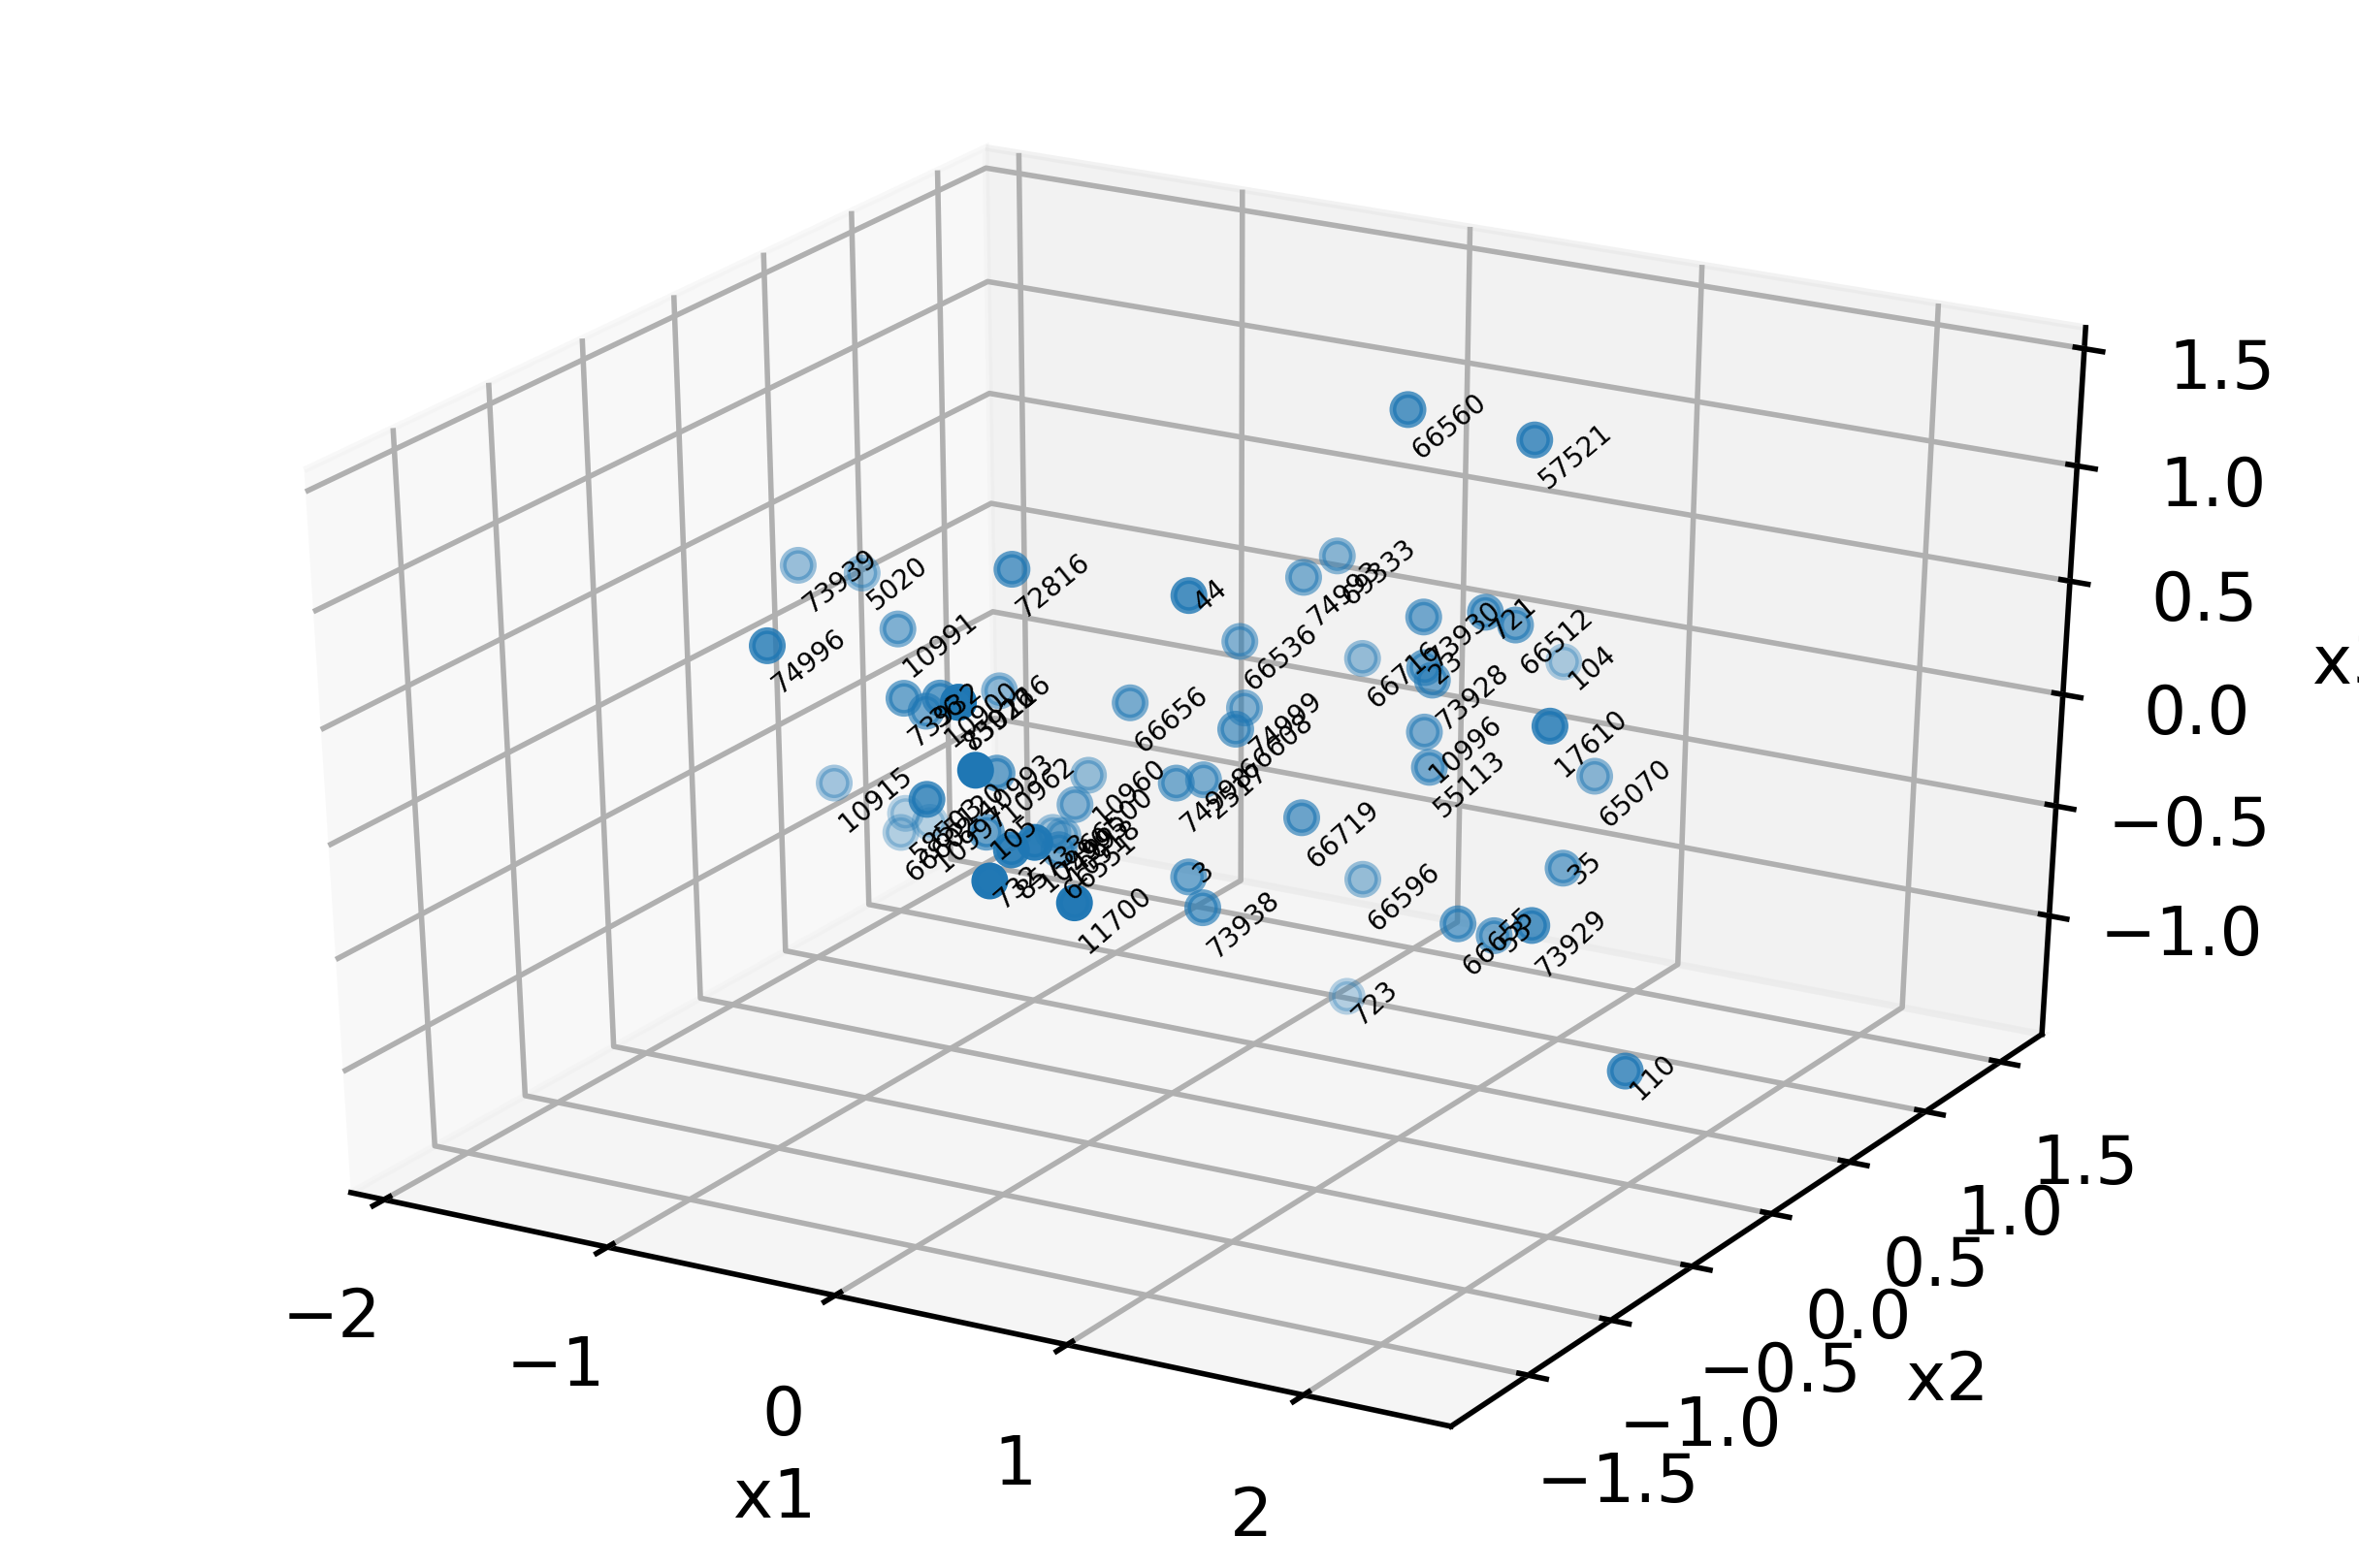

In [40]:
fig = plt.figure(dpi=500)
ax = fig.add_subplot(111, projection='3d')

idx = np.random.randint(embedding_r.shape[0], size=(60,))
xx, yy, zz = embedding_r[idx, 0], embedding_r[idx, 1], embedding_r[idx, 2]

ax.scatter(xx, yy, zz)

for x, y, z, txt in zip(xx, yy, zz, embedding.index):
    ax.text(x, y, z, inv_map[txt], zdir='y', fontsize=4)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3');